# Lab Assignment Six: Convolutional Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate a deep learning architecture and tune hyper-parameters.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela.

2) Naim Barnett

## Dataset Selection

Data Set : Intel Image Classification - https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test

### Overview and Business Understanding

This dataset is imported from kaggle via this link (https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test). It is a very convenient dataset for our purposes as it contains around 25,000 images of size 150x150 distributed under 6 categories {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }, therefore it satisfies the requirements for this lab. It also has a well defined prediction task which is to classify the images into one of the 6 categories we defined.

For a more detailed description of the dataset, The 25,000 is distributed among three different folders, (train, test, and prediction). For our purposes, we will mainly focus on the images in the (train) folder, their number is 14034 images. In the (train) folder, we have six folders, a folder for each category of our six categories and each one of these folders has many images of the respective category with different orientations and shapes. Moreover, the each of the images is of the (RGB) type, thus having 3 channels per pixel, and we have 150 x 150 = 22500 pixels.

It is worth noting that I relied heavily on the professor's notebook, so everything I took from there will be cited with "(Inspired by the professor's notebook)" beforehand.

# Preparation

In [28]:
"""Loading the images data"""
import numpy as np
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import cv2
#Creating labels and containers for the training and test data
class_names = {'buildings' :0,'forest' : 1, 'glacier' : 2, 'mountain' : 3, 'sea' : 4, 'street' : 5 }
X_train = []
y_train = []
X_test = []
y_test = []
img_wh = 150       #image dimensions (chosen so that the image appears clear)
NUM_CLASSES = 6    #The number of different categories of images we have

# a loop that reads the images from the data folder, stores them into their respective train and test containers
for name in class_names:
    directory = '../../Data/Lab_2_Dataset/seg_train/seg_train/' + name + '/' 
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        image = cv2.resize(image,(img_wh,img_wh))
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       (R,G,B) = cv2.split(image)            for dealing with three channels and splitting them
        i = image.flatten()
        X_train.append(i)
        y_train.append(class_names[name])
    directory = '../../Data/Lab_2_Dataset/seg_test/seg_test/' + name + '/' 
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        image = cv2.resize(image,(img_wh,img_wh))
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       (R,G,B) = cv2.split(image)            for dealing with three channels and splitting them
        i = image.flatten()
        X_test.append(i)
        y_test.append(class_names[name])

#Shuffeling the images in the containers as they are retrieved class by class as shown in the for loop
X_train, y_train = shuffle(X_train,y_train,random_state=0)
X_test, y_test= shuffle(X_test,y_test,random_state=0)

#Converting our containers into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("A visualization of the table of 1-D image features (each row = one image):")
print(X_train)
print('The shape of the training set: ' + str(X_train.shape))
print('The shape of the testing set: ' + str(X.shape))

A visualization of the table of 1-D image features (each row = one image):
[[214 167 140 ...  23  11   9]
 [236 236 236 ...  66  66  66]
 [  8   4   0 ...   1   2   0]
 ...
 [236 174 126 ...  40  43  41]
 [184 165 158 ...  66  64  93]
 [ 47  36  32 ... 145 144 146]]
The shape of the training set: (14034, 67500)
The shape of the testing set: (3000, 67500)


In [29]:
"""Visualizing some data instances we have"""
# function to return key for any value
def get_key(val):
    for key, value in class_names.items():
        if val == value:
            return key

# a helper plotting function (Inspired by the professor's notebook)
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((img_wh,img_wh,3)))
        plt.title(get_key(titles[i]), size=16)
        plt.xticks(())
        plt.yticks(())

Some of the training data:


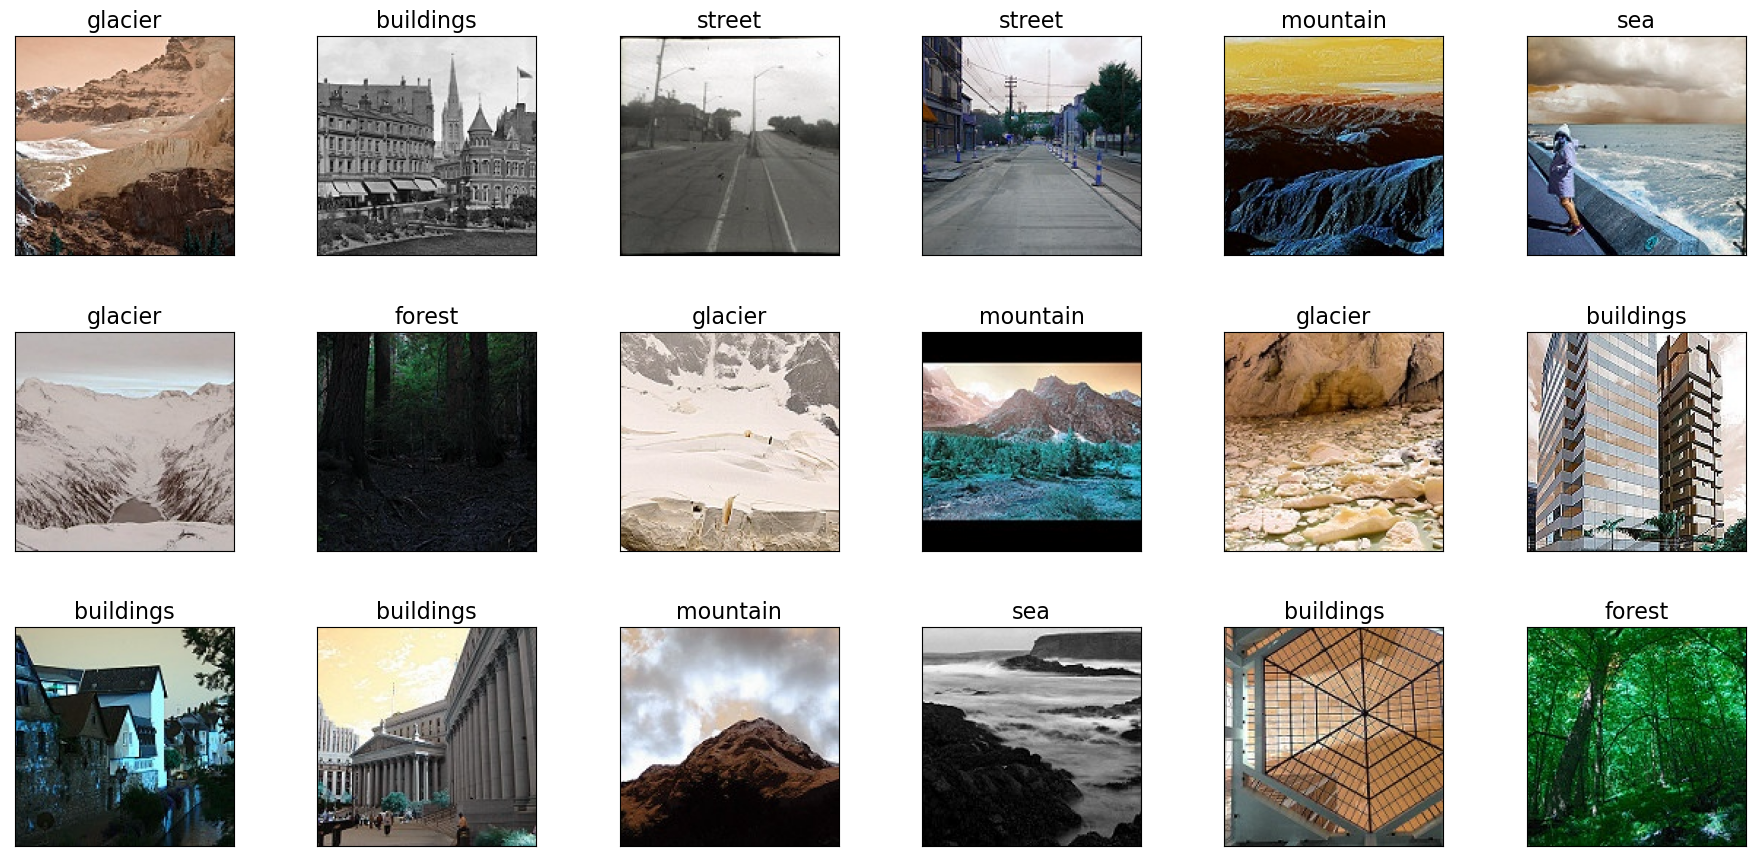

In [30]:
#Plotting some of the training data
print("Some of the training data:")
plot_gallery(X_train, y_train)

Some of the testing data:


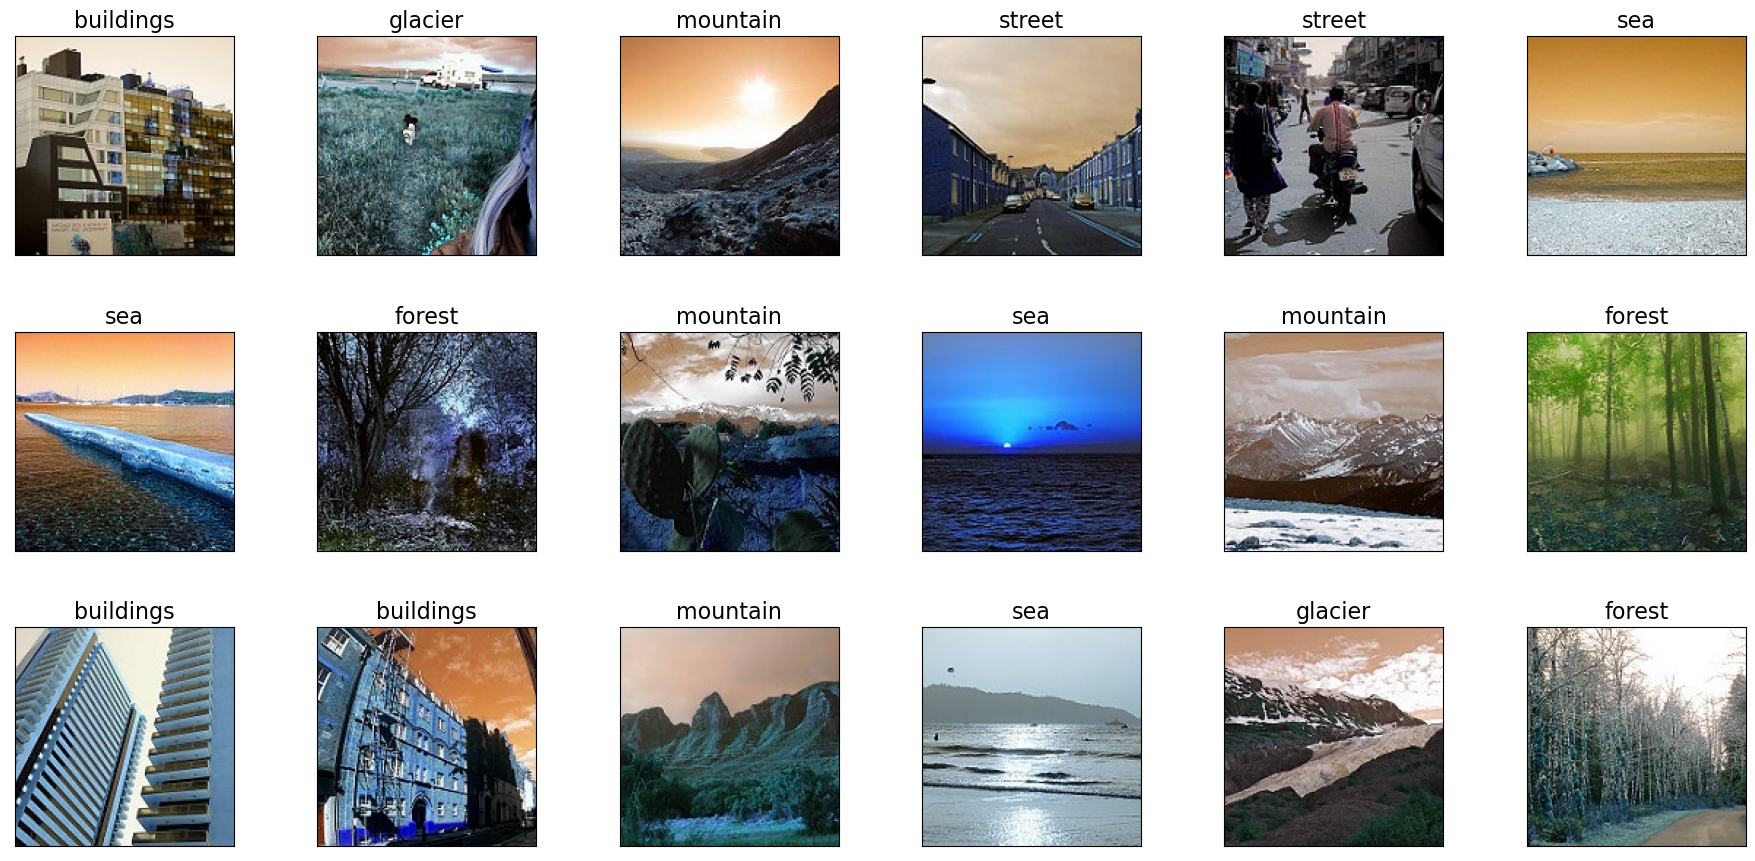

In [31]:
#Plotting some of the testing data
print("Some of the testing data:")
plot_gallery(X_test, y_test)

## Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Third parties (like image search engines) would be really interested in our algorithm to be able to initially have a classifier that tells them whether a provided image falls under one of the 6 categories. The number of categories can also be expanded by including images from other classes and make the prediction task more and more inclusive of more relevant third parties. This data is really important because it is through which the machine can learn the different ways the image of a certain category can exist, the number of ways the pictures are taken, the different types of (buildings, forests, ...etc!) included can be very helpful in having a very powerful algorithm that can capture even the most unclear building/forests/..etc! image. Therefore, the sole judge of the efficiency of our algorithm is whether it well be able to predict data's classes with hidden labels correctly or not, and to which extent, of course, having the maximum efficiency in this regard is what only can be considered as a useful algorithm for third parties. Thus, an algorithm that predicts the correct label 80% of the time is always better than one that does it 60% of the time, and so on. Moreover, having a false positive or a false negative is equally unfavorable. Consequently, this is probably one of the rare casese when "accuracy" will be considered a good performance metric for our purposes.

## Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [32]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([2191, 2271, 2404, 2512, 2274, 2382]))

Looking into the number of instances in the training set (14034 instances) and their distribution among different classes, we can see that there is no drastic difference between the number of each class compared to the others, more or less, they all exist in the same ratio. Thus, since we have the nearly-balanced data, we might be compelled to use shuffle splits with less number of splits than 10 to be more computationally efficient. However, we also need the splits to be stratified to make sure we are mirorring the shape of the original training set. Thus, we decide to go on with using sklearn's StratifiedShuffleSplit.

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)


# Modeling (6 points total)

## [1.5 points]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras fit generator as a pre-processing step OR in the optimization loop.

## [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

## [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. 


## [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP)  

# Exceptional Work (1 points total)

## You have free reign to provide additional analyses. 

## One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance.